<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Thesis/ThesisSarahGhysels_CNN_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

## Preparation

### Installing files and importing functions

In [ ]:
#installing necessary files
%pip install split-folders tqdm
%pip install Augmentor

In [ ]:
#Linking google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#Importing necessary functions
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import optim
from torchvision import datasets, models
from collections import OrderedDict
import Augmentor
import torch.nn as nn
import torchvision.transforms as transforms
from google.colab import files
import pandas as pd
import random
import shutil
from sklearn import metrics
import re
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, resnet50, ResNet50_Weights, densenet161, DenseNet161_Weights, vgg16, VGG16_Weights
import cv2
import splitfolders
import random

### Defining functions

#### Dataset and dataloader

In [ ]:
#Create PyTorch dataset
class imagedataset(Dataset):
    def __init__(self, y_values, dir_image,id_image, transform=None):
        # csv_file (string): Path to the csv file with annotations, root_dir (string): Directory with all the images
        self.DMY_dataframe = y_values
        self.dir_image = dir_image
        self.transform = transform
        self.id_image = id_image
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
      return len(self.DMY_dataframe)

    def __getitem__(self, idx):
        image = cv2.imread(self.dir_image[idx])
        image = self.to_tensor(image)
        DMYield = self.DMY_dataframe[idx]
        id_image = self.id_image[idx]

        if self.transform:
            image = self.transform(image)

        return image, DMYield, id_image

In [ ]:
def data_loader(train_dataset, val_dataset,test_dataset,batch_size = 256, workers = 1, pin_memory = True): #test_dataset

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size = batch_size,
      shuffle = True,
      num_workers = workers,
      pin_memory = pin_memory,
      sampler = None
  )

  val_loader = torch.utils.data.DataLoader(
      val_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = workers,
      pin_memory = pin_memory
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = workers,
      pin_memory = pin_memory
  )

  return train_loader, val_loader, test_loader

#### Oversampling and data augmentation

In [ ]:
#Function to generate extra data by oversampling with Augmentor (creates new images by geometric transformations of existing ones)
def oversample_func(split_directory, folders, target_folders, requiredNbrOfImages):
    for i in range(len(folders)):
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages
        seed = random.randint(0, 1000)

        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.flip_left_right(probability=0.5)
            p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded, multi_threaded=False)

#### Model

##### Pre-trained models

In [ ]:
# #looking at models
# weights = models.DenseNet161_Weights.DEFAULT
# model = models.densenet161(weights=weights)
# print(dict(model.named_children()).keys())
# print(model.classifier)
# weights2 = models.VGG16_Weights.DEFAULT
# model2 = models.vgg16(weights=weights2)
# print(dict(model2.named_children()).keys())
# print(model2.classifier)

In [ ]:
# Functie geeft gewenste CNN model terug
def make_model(structure, preTrained):
  output_size = 1
  if structure=="densenet161":
      weights = models.DenseNet161_Weights.DEFAULT
      model = models.densenet161(weights=weights)
      input_size = 2208
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(2208, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))

      model.classifier = regressor
  elif structure=="vgg16":
      weights = models.VGG16_Weights.DEFAULT
      model = models.vgg16(weights=weights)
      input_size = 25088
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(25088, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))

      model.classifier = regressor
  elif structure=="EfficientNet":
      weights = EfficientNet_V2_S_Weights.DEFAULT
      model = efficientnet_v2_s(weights = weights)
      input_size =1280
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(1280, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))
      model.classifier = regressor
  elif structure=="ResNet":
      weights = ResNet50_Weights.DEFAULT
      model = resnet50(weights = weights)
      input_size =2048
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(2048, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))

      model.fc = regressor
  else:print('wrong name model')
  if preTrained ==True:
    for param in model.parameters():
        param.requires_grad = False #The gradients in the model are frozen
    if structure=="ResNet" :
      for paramNew2 in model.fc.parameters(): paramNew2.requires_grad = True
    else :
      for paramNew in model.classifier.parameters():
        paramNew.requires_grad = True
  else:
    for param in model.parameters(): param.requires_grad=True
  return model

In [ ]:
# #checking which parameters are frozen
# model=make_model("vgg16", preTrained=True)
# for name, param in model.named_parameters():
#     print('Name: ', name, ' Requires_Grad: ', param.requires_grad)
# #correct

## Training the model

### Data loading and preparation

#### Loading data (and oversampling)

In [ ]:
# define working directories
working_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Train'#NewClips
split_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/'
model_save_location = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/OutputCNN/'
test_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test'

#split folder verwijderen
if os.path.isdir(split_directory): shutil.rmtree(split_directory)

splitfolders.ratio(working_directory, output=split_directory, seed=rand, ratio=(0.9, 0.1), group_prefix=None, move=False) #test: 0.9-0.1 and seed = rand (before 0.8-0.2 and one of the three seeds)


#creating directories
train_path = split_directory + 'train/'
if not os.path.exists(train_path):os.makedirs(train_path)
val_path = split_directory + 'val/'
if not os.path.exists(val_path):os.makedirs(val_path)

715


Copying files: 3772 files [02:16, 27.60 files/s]


In [ ]:
#Test data loading
test_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test'

In [ ]:
# #Oversample
# #there should be 2720 Discard images in the train set and 297 Keep
# requiredNbrOfImages=0
# target_dir=train_path
# if not os.path.exists(target_dir):os.makedirs(target_dir)
# folders = [os.path.join(train_path, folder) for folder in next(os.walk(train_path))[1]]
# target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(train_path))[1]]
# oversample_func(split_directory,  folders, target_folders, requiredNbrOfImages)

saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Keep
Initialised with 297 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Keep.

Processing BLOK1R16P23.png: 100%|██████████| 1063/1063 [00:09<00:00, 110.50 Samples/s]


In [ ]:
#reading in the DMY data
Dataset_multigras= pd.read_csv("/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv", sep=';')
DMY = Dataset_multigras['DMY (kg/ha)']

#### Creating threshold

In [ ]:
#determining threshold
#First transforming all values to integers and transforming error to negative number other errors are denoted with
DMY_int=[]
for i in range(0,len(DMY)):
   try: DMY_int.append(int(DMY[i]))
   except ValueError: DMY_int.append(-544)

DMY_int.sort()
Top10percent = round(9*4224/10)
threshold = DMY_int[Top10percent]
print(threshold)

6811


#### Creating datasets

In [ ]:
#Matching images with DMY values

#training data
# read the training data labels
train_labels = os.listdir(train_path)
# sort the training labesl
train_labels.sort()
# empty list to hold feature vectors and labels
dir_image_train = []
id_image_train = []
y_values_train = []

# loop over the training data sub folder
for training_name in train_labels:
  # join the training data path and each class training folder
  dir = os.path.join(train_path, training_name)
  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= np.float32(DMY[index])
    except ValueError:y=-1
    if y>=threshold: y = 1 #changed
    elif y>-1 and y<threshold: y = 0

    # update the list of labels and feature vectors
    if y>-1: #changed
      y_values_train.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_train.append(image_dir)
      id_image_train.append(file)

#validation data
# read the validation data labels
val_labels = os.listdir(val_path)
# sort the validation labels
val_labels.sort()
# empty list to hold feature vectors and labels
dir_image_val = []
id_image_val = []
y_values_val = []
# loop over the validation data sub folder
for val_name in val_labels:
  # join the validation data path and each class validation folder
  dir = os.path.join(val_path, val_name)
  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= np.float32(DMY[index])
    except ValueError:y=-1
    if y>=threshold: y = 1 #changed
    elif y>-1 and y<threshold: y = 0

    # update the list of labels and feature vectors
    if y>-1: #changed
      y_values_val.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_val.append(image_dir)
      id_image_val.append(file)

In [ ]:
#matching test images with DMY values
#test data
# read the test data labels
test_labels = os.listdir(test_directory)
# sort the test labels
test_labels.sort()
# empty list to hold feature vectors and labels
dir_image_test = []
id_image_test = []
y_values_test = []
# loop over the test data sub folder
for test_name in test_labels:
  # join the test data path and each class test folder
  dir = os.path.join(test_directory, test_name)
  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= np.float32(DMY[index])
    except ValueError:y=-1
    if y>=threshold: y = 1
    elif y>-1 and y<threshold: y = 0

    # update the list of labels and feature vectors
    if y>-1:
      y_values_test.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_test.append(image_dir)
      id_image_test.append(file)

#### Creating positive weights for use in model

In [ ]:
positive_weights= (y_values_train.count(0))/(y_values_train.count(1))
print(positive_weights)
positive_weights = torch.tensor(positive_weights)

8.574850299401197


### Hyperparameters

In [ ]:
# Here all hyperparameters are defined
Batch_size = 32 #32, 64
Learning_rate = 0.0001
Num_workers = 0
ARCH = 'densenet161' #'vgg16', 'densenet161', 'own_model', "EfficientNet", "ResNet"

In [ ]:
# Transform the data to the specific input needed for the pretrained model
if ARCH == 'densenet161':
    transformer = models.DenseNet161_Weights.IMAGENET1K_V1.transforms(antialias=True)
elif ARCH == 'vgg16':
    transformer = models.VGG16_Weights.IMAGENET1K_FEATURES.transforms(antialias = True)
elif ARCH == 'EfficientNet':
    transformer = models.EfficientNet_V2_S_Weights.DEFAULT.transforms(antialias=True)
elif ARCH == 'ResNet':
    transformer = models.ResNet50_Weights.DEFAULT.transforms(antialias = True)

dataset_train = imagedataset(y_values_train, dir_image_train, id_image_train, transform = transformer)
dataset_val = imagedataset(y_values_val, dir_image_val, id_image_val, transform = transformer)
dataset_test = imagedataset(y_values_test, dir_image_test, id_image_test, transform = transformer)

train_loader, val_loader, test_loader = data_loader(dataset_train, dataset_val,dataset_test, Batch_size, Num_workers, False)
print("Training Set: " + str(len(train_loader.dataset)))
print("Validation Set: " + str(len(val_loader.dataset)))
print("Test Set: " + str(len(test_loader.dataset)))

Training Set: 3198
Validation Set: 359
Test Set: 393


### Running the model

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'y_pred contains classes not in y_true', )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1/10... |  Train Loss 0.9105 |  Train Accuracy 0.7507 | Validation Loss 0.8475 |  Validation Accuracy 0.8248 | Recall 0.9737 | F2_score 0.6314
Test Balanced Accuracy 0.7695 |
Test F2 score 0.5692 |


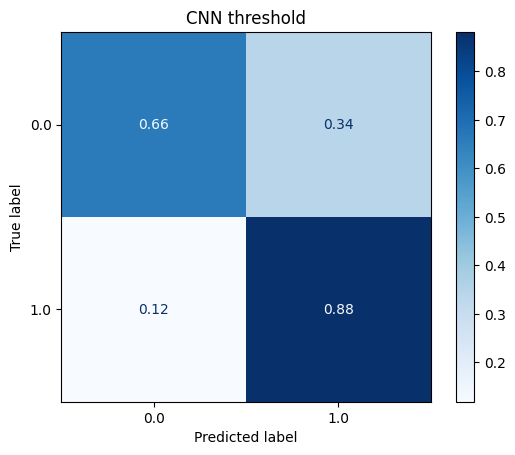

Epoch: 2/10... |  Train Loss 0.6998 |  Train Accuracy 0.8391 | Validation Loss 0.7554 |  Validation Accuracy 0.8368 | Recall 0.8947 | F2_score 0.6615
Test Balanced Accuracy 0.8098 |
Test F2 score 0.6295 |


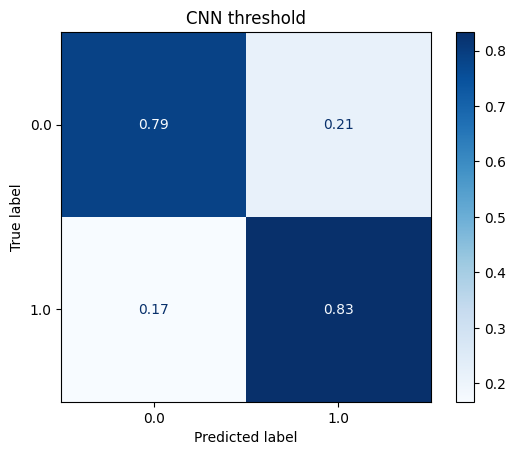

Epoch: 3/10... |  Train Loss 0.5880 |  Train Accuracy 0.8691 | Validation Loss 0.9205 |  Validation Accuracy 0.7750 | Recall 0.7368 | F2_score 0.5833
Test Balanced Accuracy 0.7898 |
Test F2 score 0.6061 |
Epoch: 4/10... |  Train Loss 0.5179 |  Train Accuracy 0.8786 | Validation Loss 0.8469 |  Validation Accuracy 0.8266 | Recall 0.9211 | F2_score 0.6410
Test Balanced Accuracy 0.7818 |
Test F2 score 0.5863 |
Epoch: 5/10... |  Train Loss 0.3987 |  Train Accuracy 0.9164 | Validation Loss 2.2919 |  Validation Accuracy 0.8014 | Recall 0.7368 | F2_score 0.6278
Test Balanced Accuracy 0.7935 |
Test F2 score 0.6151 |
Epoch: 6/10... |  Train Loss 0.3979 |  Train Accuracy 0.9131 | Validation Loss 1.9221 |  Validation Accuracy 0.7798 | Recall 0.6842 | F2_score 0.5963
Test Balanced Accuracy 0.8011 |
Test F2 score 0.6360 |
Epoch: 7/10... |  Train Loss 0.3778 |  Train Accuracy 0.9206 | Validation Loss 0.8029 |  Validation Accuracy 0.8196 | Recall 0.8947 | F2_score 0.6343
Test Balanced Accuracy 0.7646 

In [ ]:
model = make_model(ARCH, False) #True, False

# Define optimizer and loss function
criterion=nn.BCEWithLogitsLoss(pos_weight = positive_weights)
optimizer = optim.Adam(model.parameters(), lr=Learning_rate) #model.classifier.parameters or model.parameters or model.fc.parameters
model_param_dir = model_save_location +'parameters'
model_param_dir_all = model_save_location +'all_parameters'

epochs = 10
if torch.cuda.is_available(): model.to('cuda')
train_loss = []
train_accuracy = []
Val_accuracy = []
Val_losses = []
Best_val_accuracy =0
Best_val_F2 = 0
Best_param=None
all_params = {}

for e in range(epochs):
    #train loop
    model.train()
    train_all_losses = []
    train_all_accuracies = []

    for batch in train_loader:
        optimizer.zero_grad()
        inputs, labels, id = batch
        if torch.cuda.is_available(): inputs, labels = inputs.to('cuda'), labels.to('cuda')
        labels = labels.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)
        labels = labels.float()
        #loss
        loss = criterion(outputs, labels)
        #accuracy
        outputs = outputs.cpu()
        labels = labels.cpu().numpy()
        outputs_np = outputs.detach().numpy()
        outputs_sig = 1/(1 + np.exp(-outputs_np))
        outputs_round = np.round(outputs_sig)
        accuracy = metrics.balanced_accuracy_score(labels, outputs_round)
        #backward pass
        loss.backward()
        optimizer.step()

        train_all_losses.append(loss.item())
        train_all_accuracies.append(accuracy.item())

    #eval loop
    model.eval()
    Val_all_losses = []
    Val_predictions = []
    Val_labels = []
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs, val_labels, val_id = val_batch
            if torch.cuda.is_available(): val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
            val_labels = val_labels.unsqueeze(1)
            val_outputs = model(val_inputs)
            val_labels = val_labels.float()
            #loss
            val_loss = criterion(val_outputs, val_labels)
            Val_all_losses.append(val_loss.item())
            #accuracy
            val_outputs = val_outputs.cpu()
            val_labels = val_labels.cpu()
            val_outputs_np = val_outputs.detach().numpy()
            val_outputs_sig = 1/(1 + np.exp(-val_outputs_np))
            val_outputs_round =np.round(val_outputs_sig)
            val_outputs_tensor = torch.from_numpy(val_outputs_round)
            Val_predictions.append(val_outputs_tensor)
            Val_labels.append(val_labels)

    #evaluation epoch
    Val_predictions= torch.cat(Val_predictions)
    Val_labels=torch.cat(Val_labels)
    val_accuracy = metrics.balanced_accuracy_score(Val_labels, Val_predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(Val_labels, Val_predictions).ravel()
    recall = tp/(tp+fn)
    F2_score = metrics.fbeta_score(Val_labels, Val_predictions, beta=2)
    Val_losses.append(np.mean(Val_all_losses))
    train_loss.append(np.mean(train_all_losses))
    train_accuracy.append(np.mean(train_all_accuracies))


    print("Epoch: {}/{}... | ".format(e+1, epochs),
    "Train Loss {:.4f} | ".format(np.mean(train_all_losses)),
    "Train Accuracy {:.4f} |".format(np.mean(train_all_accuracies)),
    "Validation Loss {:.4f} | ".format(np.mean(Val_all_losses)),
    "Validation Accuracy {:.4f} |".format(val_accuracy),
    "Recall {:.4f} |".format(recall),
    "F2_score {:.4f}".format(F2_score))

#### The test performance that is described in the thesis is chosen by taking the best epoch according to the validation set performance!!
# If the best test set would have been used, it would not have been independent anymore.
    #test set
    #Creating test predictions
    model.eval()
    Test_predictions = []
    Test_labels = []
    with torch.no_grad():
      for test_batch in test_loader:
          test_inputs, test_labels, test_id = test_batch
          if torch.cuda.is_available(): test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')
          test_labels = test_labels.unsqueeze(1)
          test_outputs = model(test_inputs)
          test_labels = test_labels.float()
          #accuracy
          test_outputs = test_outputs.cpu()
          test_labels = test_labels.cpu()
          test_outputs_np = test_outputs.detach().numpy()
          test_outputs_sig = 1/(1 + np.exp(-test_outputs_np))
          test_outputs_round =np.round(test_outputs_sig)
          test_outputs_tensor = torch.from_numpy(test_outputs_round)
          Test_predictions.append(test_outputs_tensor)
          Test_labels.append(test_labels)

    #evaluation epoch
    Test_predictions= torch.cat(Test_predictions)
    Test_labels=torch.cat(Test_labels)
    Test_accuracy = metrics.balanced_accuracy_score(Test_labels, Test_predictions) #the average of recall obtained on each class.
    #a false negative rate is also interesting to determine because a FN is the worst for a breeder
    tn, fp, fn, tp = metrics.confusion_matrix(Test_labels, Test_predictions).ravel()
    F2_score_test = metrics.fbeta_score(Test_labels, Test_predictions, beta=2)
    print("Test Balanced Accuracy {:.4f} ".format(Test_accuracy))
    print("Test F2 score {:.4f} ".format(F2_score_test))
    if val_accuracy > Best_val_accuracy and F2_score > Best_val_F2:
      Best_val_accuracy = val_accuracy
      Best_val_F2 = F2_score
      val_confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(Test_labels, Test_predictions, normalize='true',cmap='Blues')
      plt.title('CNN threshold')
      plt.show()
